In [77]:
import numpy as np
import pandas as pd
import yaml
import torch
from copy import deepcopy
import matplotlib.pyplot as plt
from celldreamer.eval.eval_utils import normalize_and_compute_metrics
import scipy.sparse as sp
import scipy
from tqdm import tqdm 

from torch import nn
import pickle
import scanpy as sc    

from celldreamer.data.scrnaseq_loader import RNAseqLoader
from celldreamer.models.featurizers.category_featurizer import CategoricalFeaturizer
from celldreamer.models.fm.fm import FM
from celldreamer.eval.optimal_transport import wasserstein
import random
from celldreamer.models.base.encoder_model import EncoderModel
from celldreamer.models.base.utils import unsqueeze_right

from celldreamer.paths import DATA_DIR

device  = "cuda" if torch.cuda.is_available() else "cpu"

## Step 1: Initialize data

In [78]:
dataset_config = {'dataset_path': DATA_DIR / 'processed' / 'classifier_experiment_hlca' / 'hlca_train.h5ad',
                    'layer_key': 'X_counts',
                    'covariate_keys': ['cell_type'],
                    'conditioning_covariate': 'cell_type',
                    'subsample_frac': 1,
                    'encoder_type': 'learnt_autoencoder',
                    'n_dimensions': None,
                    'one_hot_encode_features': True,
                    'split_rates': [0.90, 0.05, 0.05],
                    'cov_embedding_dimensions': None}

data_path = dataset_config["dataset_path"]

dataset = RNAseqLoader(data_path=data_path,
                                layer_key=dataset_config["layer_key"],
                                covariate_keys=dataset_config["covariate_keys"],
                                subsample_frac=dataset_config["subsample_frac"], 
                                encoder_type=dataset_config["encoder_type"])

in_dim = dataset.X.shape[1]
size_factor_statistics = {"mean": dataset.log_size_factor_mu, 
                                  "sd": dataset.log_size_factor_sd}
n_cat = len(dataset.id2cov["cell_type"])

id2cov = dataset.id2cov

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


## Step 2: Initialize encoder

In [79]:
encoder_config = {
    "x0_from_x_kwargs": {
        "dims": [512, 256, 100],
        "batch_norm": True,
        "dropout": False,
        "dropout_p": 0.0
    },
    "learning_rate": 0.001,
    "weight_decay": 0.00001,
    "covariate_specific_theta": False
}

state_dict_path = "/home/icb/alessandro.palma/environment/celldreamer/project_folder/experiments/CLASSIFICATION_off_train_autoencoder_hlca_core/3dde9d9c-2fbc-4417-bdd7-9e8ebe1c948b/checkpoints/last.ckpt"

In [80]:
encoder_model = EncoderModel(in_dim=in_dim,
                              n_cat=n_cat,
                              conditioning_covariate=dataset_config["conditioning_covariate"], 
                              encoder_type=dataset_config["encoder_type"],
                              **encoder_config)
encoder_model.eval()

encoder_model.load_state_dict(torch.load(state_dict_path)["state_dict"])

<All keys matched successfully>

## Step 3: Initialize FM model

In [81]:
generative_model_config = {'learning_rate': 0.0001,
                            'weight_decay': 0.00001,
                            'antithetic_time_sampling': True,
                            'sigma': 0.0001}

In [82]:
ckpt = torch.load("/home/icb/alessandro.palma/environment/celldreamer/project_folder/experiments/CLASSIFIER_off_fm_resnet_autoencoder_hlca_core_whole_genome/b32358e8-ce61-4095-aa92-a9a153cbc8fb/checkpoints/last.ckpt")

denoising_model = ckpt["hyper_parameters"]["denoising_model"]
denoising_model.multimodal = False

In [83]:
ckpt["hyper_parameters"]

{'encoder_model': EncoderModel(
   (x0_from_x): MLP(
     (net): Sequential(
       (0): Sequential(
         (0): Linear(in_features=2000, out_features=512, bias=True)
         (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         (2): ELU(alpha=1.0)
       )
       (1): Sequential(
         (0): Linear(in_features=512, out_features=256, bias=True)
         (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         (2): ELU(alpha=1.0)
       )
       (2): Linear(in_features=256, out_features=100, bias=True)
     )
   )
   (x_from_x0): MLP(
     (net): Sequential(
       (0): Sequential(
         (0): Linear(in_features=100, out_features=256, bias=True)
         (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         (2): ELU(alpha=1.0)
       )
       (1): Sequential(
         (0): Linear(in_features=256, out_features=512, bias=True)
         (1): BatchNorm1d(512, eps=1e

In [84]:
print(ckpt["hyper_parameters"]["feature_embeddings"]["cell_type"].embeddings.weight)
feature_embeddings = ckpt["hyper_parameters"]["feature_embeddings"]

Parameter containing:
tensor([[-2.0043e-03,  1.9233e+00, -6.7572e-01,  ..., -3.6112e+00,
          1.5947e+00,  1.7232e+00],
        [ 1.9524e-01,  4.6475e-01, -2.9813e+00,  ..., -1.2458e+00,
         -1.2097e+00, -1.4441e+00],
        [ 1.3815e+00,  1.8965e+00,  1.6308e-01,  ..., -3.7239e-01,
          1.9261e+00, -7.9133e-02],
        ...,
        [ 9.2174e-01,  7.0955e-02, -1.9634e+00,  ...,  1.5019e+00,
          5.7258e-01, -7.9936e-01],
        [ 1.9416e-02, -6.2857e-01, -9.6775e-01,  ...,  1.7674e+00,
         -6.0925e-01, -1.0126e+00],
        [ 9.2029e-01,  1.7621e+00,  2.3160e+00,  ...,  9.3106e-01,
          2.3219e-01,  1.1980e+00]], device='cuda:0', requires_grad=True)


Initializations

In [85]:
generative_model = FM(
            encoder_model=encoder_model,
            denoising_model=denoising_model,
            feature_embeddings=feature_embeddings,
            plotting_folder=None,
            in_dim=512,
            size_factor_statistics=size_factor_statistics,
            encoder_type=dataset_config["encoder_type"],
            conditioning_covariate=dataset_config["conditioning_covariate"],
            model_type=denoising_model.model_type, 
            **generative_model_config  # model_kwargs should contain the rest of the arguments
            )

generative_model.load_state_dict(ckpt["state_dict"])
generative_model.to("cuda")

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:198: Attribute 'encoder_model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['encoder_model'])`.
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:198: Attribute 'denoising_model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['denoising_model'])`.


FM(
  (encoder_model): EncoderModel(
    (x0_from_x): MLP(
      (net): Sequential(
        (0): Sequential(
          (0): Linear(in_features=2000, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ELU(alpha=1.0)
        )
        (1): Sequential(
          (0): Linear(in_features=512, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ELU(alpha=1.0)
        )
        (2): Linear(in_features=256, out_features=100, bias=True)
      )
    )
    (x_from_x0): MLP(
      (net): Sequential(
        (0): Sequential(
          (0): Linear(in_features=100, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ELU(alpha=1.0)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
        

In [86]:
del ckpt
del encoder_model

## Read original data 

In [87]:
adata_original = sc.read_h5ad(data_path)
# sc.pp.subsample(adata_original, 0.)
adata_original.obs["size_factor"]=adata_original.X.A.sum(1)
X = torch.tensor(adata_original.layers["X_counts"].todense())

In [88]:
adata_original

AnnData object with n_obs × n_vars = 429918 × 2000
    obs: 'suspension_type', 'donor_id', 'is_primary_data', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'tissue_ontology_term_id', 'organism_ontology_term_id', 'sex_ontology_term_id', 'BMI', 'age_or_mean_of_age_range', 'age_range', 'anatomical_region_ccf_score', 'ann_coarse_for_GWAS_and_modeling', 'ann_finest_level', 'ann_level_1', 'ann_level_2', 'ann_level_3', 'ann_level_4', 'ann_level_5', 'cause_of_death', 'dataset', 'entropy_dataset_leiden_3', 'entropy_original_ann_level_1_leiden_3', 'entropy_original_ann_level_2_clean_leiden_3', 'entropy_original_ann_level_3_clean_leiden_3', 'entropy_subject_ID_leiden_3', 'fresh_or_frozen', 'leiden_1', 'leiden_2', 'leiden_3', 'leiden_4', 'leiden_5', 'log10_total_counts', 'lung_condition', 'mixed_ancestry', 'n_genes_detected', 'original_ann_highest_res', 'original_ann_level_1', 'o

## Generate and save cells

In [89]:
unique_classes = np.unique(adata_original.obs.cell_type, return_counts=True)
class_freq_dict = dict(zip(unique_classes[0], unique_classes[1]))
norm_const = np.sum(1/unique_classes[1])
class_prop_dict = dict(zip(unique_classes[0], (1/unique_classes[1])/norm_const))
class_prop = (1/unique_classes[1])/norm_const
class_idx = dict(zip(range(len(unique_classes[0])), unique_classes[0]))

In [90]:
class_freq_dict

{'B cell': 3504,
 'CD1c-positive myeloid dendritic cell': 6117,
 'CD4-positive, alpha-beta T cell': 15975,
 'CD8-positive, alpha-beta T cell': 21436,
 'T cell': 366,
 'acinar cell': 1036,
 'alveolar macrophage': 47814,
 'alveolar type 1 fibroblast cell': 4428,
 'alveolar type 2 fibroblast cell': 6382,
 'bronchial goblet cell': 1311,
 'bronchus fibroblast of lung': 963,
 'brush cell of trachebronchial tree': 146,
 'capillary endothelial cell': 18909,
 'ciliated columnar cell of tracheobronchial tree': 24878,
 'classical monocyte': 13931,
 'club cell': 28939,
 'conventional dendritic cell': 257,
 'dendritic cell': 275,
 'elicited macrophage': 22371,
 'endothelial cell of lymphatic vessel': 3092,
 'epithelial cell of alveolus of lung': 990,
 'epithelial cell of lower respiratory tract': 2943,
 'fibroblast': 266,
 'hematopoietic stem cell': 51,
 'ionocyte': 421,
 'lung macrophage': 2090,
 'lung neuroendocrine cell': 127,
 'lung pericyte': 2880,
 'mast cell': 5609,
 'mesothelial cell': 195,

In [91]:
class_prop_dict

{'B cell': 0.003566357927126055,
 'CD1c-positive myeloid dendritic cell': 0.0020429161642389567,
 'CD4-positive, alpha-beta T cell': 0.000782254658945208,
 'CD8-positive, alpha-beta T cell': 0.000582968752409484,
 'T cell': 0.03414349228592814,
 'acinar cell': 0.012062276232287355,
 'alveolar macrophage': 0.00026135688661583844,
 'alveolar type 1 fibroblast cell': 0.0028221585764791547,
 'alveolar type 2 fibroblast cell': 0.0019580880878485893,
 'bronchial goblet cell': 0.009532050477993667,
 'bronchus fibroblast of lung': 0.012976654389044339,
 'brush cell of trachebronchial tree': 0.08559259025102532,
 'capillary endothelial cell': 0.0006608767347109683,
 'ciliated columnar cell of tracheobronchial tree': 0.0005023120096731931,
 'classical monocyte': 0.0008970295152286051,
 'club cell': 0.0004318227366754103,
 'conventional dendritic cell': 0.048624584344940464,
 'dendritic cell': 0.045441884278726176,
 'elicited macrophage': 0.0005586034677327655,
 'endothelial cell of lymphatic ves

General conditional

In [102]:
n_to_sample = 300000

In [137]:
# GENERATE AUG
np.random.seed(42)
samples = np.random.choice(range(len(class_idx)), size=n_to_sample, replace=True, p=scipy.special.softmax(class_prop))
condition_names = [class_idx[sample] for sample in samples]
condition_names_unique = np.unique(condition_names, return_counts=True)
condition_names_unique = dict(zip(condition_names_unique[0], condition_names_unique[1]))
condition_names = sorted(condition_names)
size_factor = []
for ct in sorted(condition_names_unique.keys()):
    adata_original_c = adata_original[adata_original.obs["cell_type"]==ct]
    i = np.random.choice(len(adata_original_c), condition_names_unique[ct], replace=True)
    size_factor += list(adata_original_c[i].layers["X_counts"].A.sum(1))

size_factor = torch.log(torch.tensor(size_factor)).unsqueeze(1).cuda()

In [138]:
# GENERATE REAL
# ids = np.random.choice(range(len(adata_original)), size=n_to_sample)
# condition_names = list(adata_original[ids].obs.cell_type)
# log_lib_sizes = torch.log(torch.tensor(adata_original[ids].layers["X_counts"].sum(1))).cuda()

In [139]:
condition_val = torch.tensor([dataset.id2cov["cell_type"][condition_name] for condition_name in condition_names]).long()

X_generated = generative_model.batched_sample(batch_size=300,
                                            repetitions=1000,
                                            n_sample_steps=2, 
                                            covariate="cell_type", 
                                            covariate_indices=condition_val, 
                                            log_size_factor=size_factor)

In [140]:
# adata_generated = sc.AnnData(X=sp.csr_matrix(deepcopy(X_generated).cpu().numpy()))
# generated_classes = np.unique(condition_names, return_counts=True)
# generated_classes_dict = dict(zip(generated_classes[0], generated_classes[1]))
# generated_classes_dict

In [141]:
# sc.pp.normalize_total(adata_generated, target_sum=1e4)
# sc.pp.log1p(adata_generated)
# sc.tl.pca(adata_generated)
# sc.pp.neighbors(adata_generated)
# sc.tl.umap(adata_generated)

In [142]:
# adata_generated.obs["size_factor"] = adata_generated.X.sum(1)
# sc.pl.pca(adata_generated, color="size_factor", annotate_var_explained=True)
# sc.pl.umap(adata_generated, color="size_factor")

## Preprocess real data object

In [143]:
# sc.pp.normalize_total(adata_original, target_sum=1e4)
# sc.pp.log1p(adata_original)
# sc.tl.pca(adata_original)
# sc.pp.neighbors(adata_original)
# sc.tl.umap(adata_original)

In [144]:
# sc.pl.pca(adata_original, color=["size_factor", "cell_type"], annotate_var_explained=True)
# sc.pl.umap(adata_original, color=["size_factor", "cell_type"])

In [145]:
# adata_generated.write_h5ad("/home/icb/alessandro.palma/environment/celldreamer/project_folder/datasets/generated/hlca_core.h5ad")

## Merge and plot the generated and real data

In [146]:
dataset_type = ["Real" for _ in range(X.shape[0])] + ["Generated" for _ in range(X_generated.shape[0])]
dataset_type = pd.DataFrame(dataset_type)
dataset_type.columns = ["dataset_type"]
dataset_type["cell_type"] = list(adata_original.obs.cell_type)+condition_names

In [147]:
adata_merged = sc.AnnData(X=torch.cat([X, X_generated], dim=0).numpy(), 
                             obs=dataset_type)

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [148]:
# del adata_original
# del adata_generated

In [149]:
sc.pp.normalize_total(adata_merged, target_sum=1e4)
sc.pp.log1p(adata_merged)
sc.tl.pca(adata_merged)
sc.pp.neighbors(adata_merged)
sc.tl.umap(adata_merged)

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


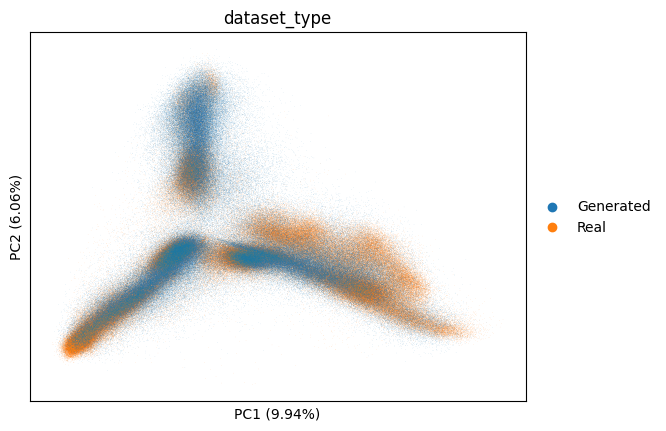

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


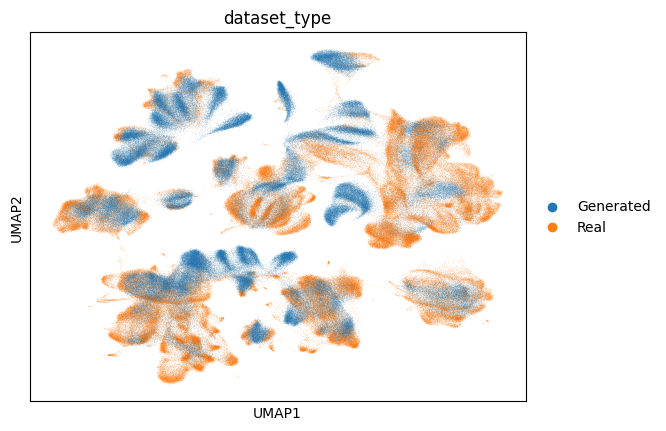

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


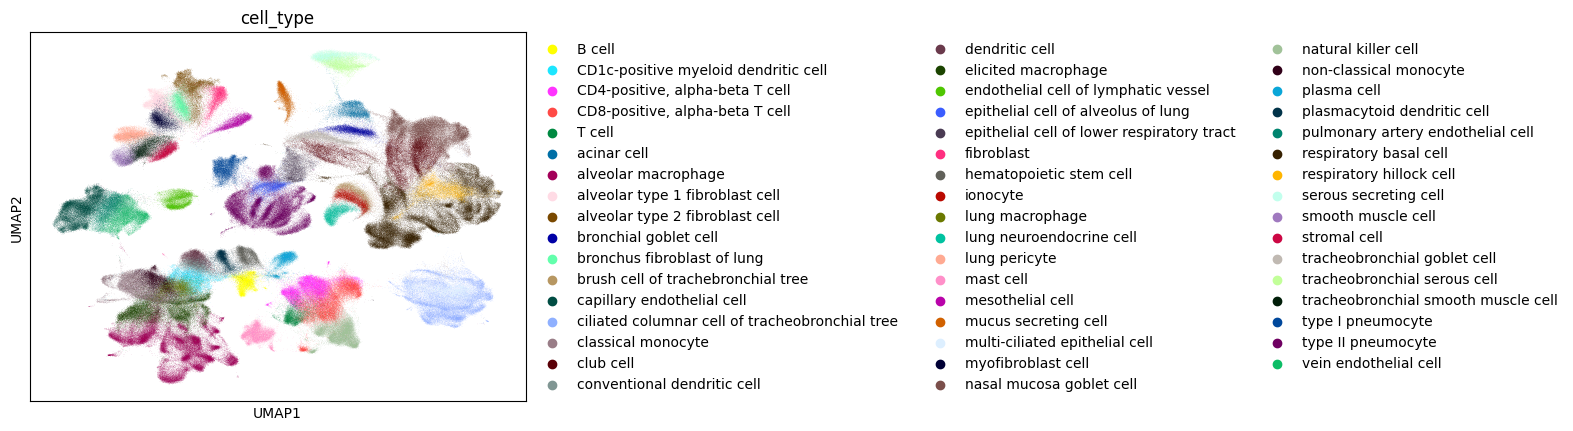

In [150]:
sc.pl.pca(adata_merged, color="dataset_type",  annotate_var_explained=True)
sc.pl.umap(adata_merged, color="dataset_type")
sc.pl.umap(adata_merged, color="cell_type")

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


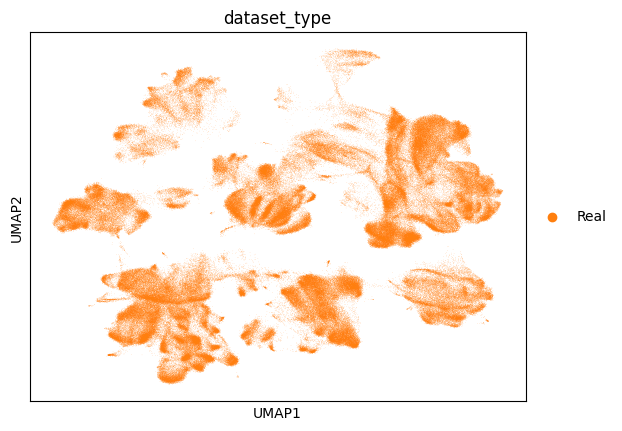

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


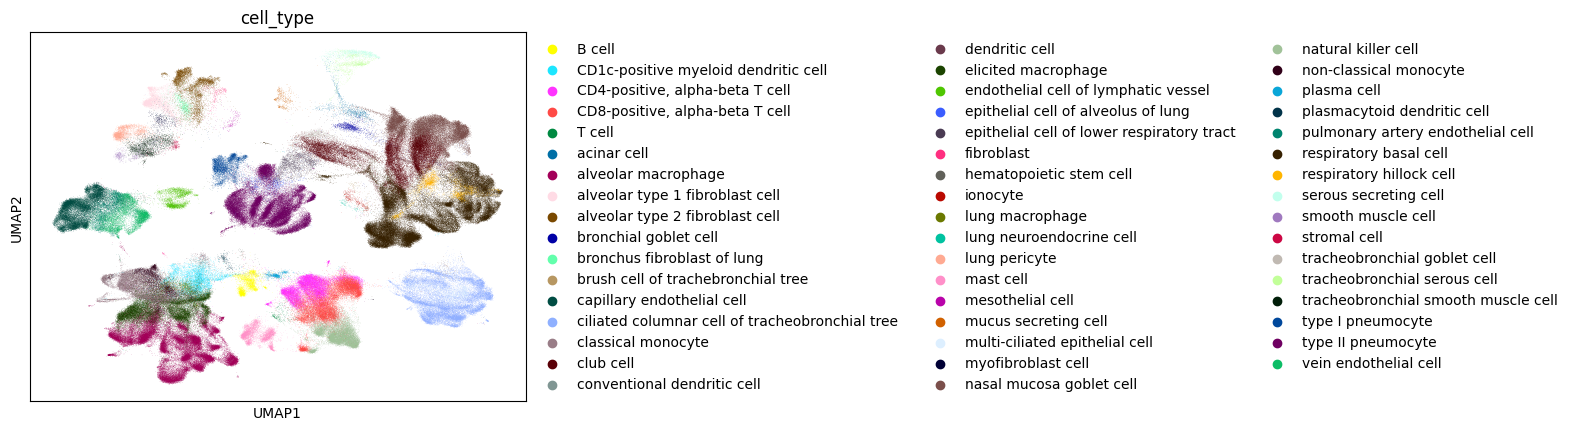

In [153]:
sc.pl.umap(adata_merged[adata_merged.obs.dataset_type=="Real"], color="dataset_type")
sc.pl.umap(adata_merged[adata_merged.obs.dataset_type=="Real"], color="cell_type")

In [162]:
# sc.write("/home/icb/alessandro.palma/environment/celldreamer/project_folder/datasets/processed/classifier_experiment_hlca/augmented/hlca_train_augmented_prop.h5ad", adata_merged)